<a href="https://colab.research.google.com/github/csabot3/liverAItutorial/blob/main/Lesson2_Part2_MR_UNet_Liver_Segmentation_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 2, Part 2: Liver Segmentation with U-Nets for MRI Data

Now we will expand on the AI modeling that we did with a U-net in lesson 2, part 1 by using the MR data in CHAOS. The MR data is a little bit different from the CT data because there are multiple organ segmentation labels for the MR data. We have labels for not just the liver but also the right kidney, the left kidney, and the spleen. So, we can either train a multi-organ model or we can modify these labels to again only focus on the liver like we did for the CT data.

We also have multiple sequences, namely T2, T1 in-phase, and T1 out-phase. We can train a model on these sequences individually. Or, we could consider trying to train a model on all 3 sequences simultaneously. We have many options, and we will only explore a small portion of them in this tutorial but we will try to set up our code so that further experimentation is relatively easy.

In [1]:
#Again we import several libraries and functions that we will use

!pip install pydicom #Not in Colab by default
!apt-get -qq install pv #Progress bar, also not in Colab

!pip install fastai --upgrade -q

from IPython.display import display,HTML

from fastai.vision.all import *

from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F

import os
import shutil
import pydicom
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from pathlib import Path
import pandas as pd
import glob
import sys

     |████████████████████████████████| 2.0 MB 7.0 MB/s 
Selecting previously unselected package pv.
(Reading database ... 155455 files and directories currently installed.)
Preparing to unpack .../archives/pv_1.6.6-1_amd64.deb ...
Unpacking pv (1.6.6-1) ...
Setting up pv (1.6.6-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 188 kB 7.1 MB/s 
     |████████████████████████████████| 60 kB 6.6 MB/s 


In [2]:
#Make sure we are using a GPU runtime!

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('We need to change the runtime and select GPU as a hardware accelerator!')
else:
  print(gpu_info)

Thu Apr 14 06:56:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#Get the CHAOS data hosted on Zenodo - takes approximately 1-2 minutes to download each train and test
!wget -q --show-progress https://zenodo.org/record/3431873/files/CHAOS_Train_Sets.zip?download=1

CHAOS_Train_Sets.zi 100%[===================>] 849.51M  4.46MB/s    in 6m 22s  


In [4]:
#We will wait to get the test set until after training
# !wget -q --show-progress https://zenodo.org/record/3431873/files/CHAOS_Test_Sets.zip?download=1

In [5]:
#Unzip the training dataset
!unzip -q  CHAOS_Train_Sets.zip\?download\=1

Now for MRI the ground truth labels cover more organs than just the liver and we have labels for the liver, the right kidney, the left kidney, and the spleen based on pixel ranges. These pixel value ranges are described in more detail in the .txt files packaged with the CHAOS data.

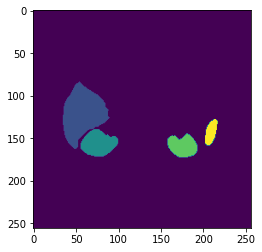

In [6]:
img1 = mpimg.imread('./Train_Sets/MR/1/T2SPIR/Ground/IMG-0002-00020.png') #This will read in the image as floats
plt.imshow(img1)

In [7]:
imArray=np.array(Image.open('./Train_Sets/MR/1/T2SPIR/Ground/IMG-0002-00020.png')) #Now let's look at loading via PIL with a Numpy array conversion

In [8]:
np.max(imArray)

252

In [9]:
imArray.shape #This pixel matrix has 256x256 size but this is not consistent across the MRI data and some slices are 320x320

(256, 256)

In [10]:
#Now based on the CHAOS dataset documentation we will make a function to adjust the pixel values based on ranges of the data
#This function will map the data labels to the format we used in part 1 for working with CT data and FastAI
def chaosrelabel(imx1):
  imx1[imx1<50]=0
  imx1[np.where(np.logical_and(imx1>=50,imx1<90))]=1 #Liver
  imx1[np.where(np.logical_and(imx1>=90,imx1<150))]=2 #Right kidney
  imx1[np.where(np.logical_and(imx1>=150,imx1<210))]=3 #Left kidney
  imx1[imx1>=210]=4 #Spleen
  return imx1



In [11]:
#We can also create a function to convert the labels to a version that only keeps the liver label data

def liverrelabel(imx1):
  imx1[imx1<50]=0
  imx1[np.where(np.logical_and(imx1>=50,imx1<90))]=1 #Liver
  imx1[imx1>=90]=0 #Organs not liver
  return imx1


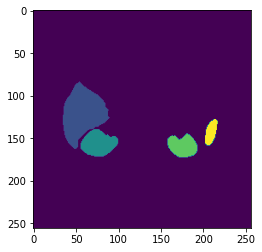

In [12]:
#Let's see how this function that we defined can be used
imx2=chaosrelabel(imArray)
plt.imshow(imx2)

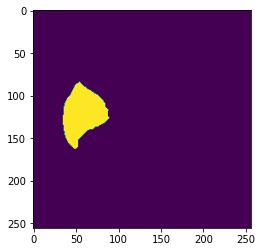

In [13]:
#Now let's see how the liver relabeling function works
imx3=liverrelabel(np.array(Image.open('./Train_Sets/MR/1/T2SPIR/Ground/IMG-0002-00020.png')))
#chaosrelabel modifies imArray as written so we would have to modify the function if we want to keep a copy of the input unchanged
#This is why we are reloading the image
plt.imshow(imx3)

In [14]:
labelpathmr=Path('./Train_Sets/MR')
trainls=os.listdir(labelpathmr)
trainls


['19',
 '37',
 '20',
 '32',
 '1',
 '36',
 '31',
 '38',
 '21',
 '15',
 '13',
 '22',
 '2',
 '3',
 '5',
 '39',
 '34',
 '33',
 '10',
 '8']

Let's look at an example DICOM slice again. This time for T2 MRI data

In [15]:
pathmr='./Train_Sets/MR/1/T2SPIR/DICOM_anon/'
mrls=os.listdir(pathmr)
mrexamplefile=pathmr+mrls[5]
mrex=pydicom.dcmread(mrexamplefile)

In [16]:
mrex

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 210
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.274354416912505316541034323232205872766
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.9590.100.1.3.100.9.4
(0002, 0013) Implementation Version Name         SH: 'MATLAB IPT 9.4'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M_SE', 'M', 'SE']
(0008, 0012) Instance Creation Date              DA: ''
(0008, 0013) Instance Creation Time              TM: ''
(0008, 0014) Instance Creator UID                UI: 1.3.46.670589.11.20182.5
(00

Now let's take a closer look at the pixel array

In [17]:
mreximg=mrex.pixel_array

In [18]:
np.min(mreximg)

0

In [19]:
np.max(mreximg)

1638

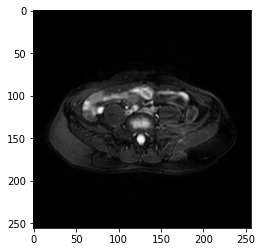

In [20]:
plt.imshow(mreximg,cmap='gray')

In [21]:
#Let's also look at an example from the T1 data
pathmr2='./Train_Sets/MR/1/T1DUAL/DICOM_anon/InPhase/'
mrls2=os.listdir(pathmr2)
mrexamplefile2=pathmr2+mrls2[5]
mrex2=pydicom.dcmread(mrexamplefile2)

In [22]:
mrex2

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 210
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.97134648712517668932373966521283995512
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.9590.100.1.3.100.9.4
(0002, 0013) Implementation Version Name         SH: 'MATLAB IPT 9.4'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M_FFE', 'M', 'FFE']
(0008, 0012) Instance Creation Date              DA: ''
(0008, 0013) Instance Creation Time              TM: ''
(0008, 0014) Instance Creator UID                UI: 1.3.46.670589.11.20182.5
(0

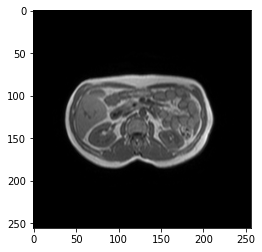

In [23]:
plt.imshow(mrex2.pixel_array,cmap='gray')

Once again, we will reformat the CHAOS dataset into a simplified format with our images and labels in pooled folders. For the CHAOS dataset, the T1 in-phase and out-phase images share the same label set. 

In [24]:
#Let's set up pooled image folders for simplicity to be similar to other datasets (CAMVID)

if not os.path.exists('./images-T2'):
  os.mkdir('./images-T2')
if not os.path.exists('./images-T1'):
  os.mkdir('./images-T1')
if not os.path.exists('./images-T1-Out'):
  os.mkdir('./images-T1-Out')
if not os.path.exists('./labels-T2'):  
  os.mkdir('./labels-T2')
#Only the in phase T1 dicoms have corresponding labels with matched names
if not os.path.exists('./labels-T1'):  
  os.mkdir('./labels-T1')
#Liver only segmentation versions
if not os.path.exists('./labels-T2-Liver'):  
  os.mkdir('./labels-T2-Liver')
if not os.path.exists('./labels-T1-Liver'):  
  os.mkdir('./labels-T1-Liver')


The MRI data can have varying matrix sizes but for our AI modeling/tensor manipulations, we will want all of our image data to be the same size. For simplicity, we will resize the data to the maximum matrix size in the dataset when we reformat it.

In [25]:
#Fixed size
fixsize=320

In [26]:

#This executes quickly since we are not manipulating the images and just rearranging them

labelpath=Path('./Train_Sets/MR')
trainls=os.listdir(labelpath)


for f1 in trainls:

  #Loop through the T1 images

  dcls=sorted(os.listdir(labelpath/f1/'T1DUAL/DICOM_anon/InPhase'))
  dclsO=sorted(os.listdir(labelpath/f1/'T1DUAL/DICOM_anon/OutPhase')) #These dcms are offset as -1 relative to the in phase
  labls=sorted(os.listdir(labelpath/f1/'T1DUAL/Ground'))
  for x1 in range(0,len(dcls)):
    dcpick=labelpath/f1/'T1DUAL/DICOM_anon/InPhase'/dcls[x1]
    labpick=labelpath/f1/'T1DUAL/Ground'/labls[x1]
    savestem=labls[x1].split('.')[0]
    savenamekeep=str(f1)+'-'+savestem #Does not include character suffix
    mrex=pydicom.dcmread(dcpick)
    mrimg=mrex.pixel_array#pydicom.pixel_data_handlers.util.apply_modality_lut(mrex.pixel_array,mrex)
    Image.fromarray(mrimg.astype(np.float32)).resize((fixsize,fixsize)).save('./images-T1/'+str(f1)+'-'+savestem+'.tif')

    #Load the out phase under its label but save it under the inphase label in a separate folder
    dcpickO=labelpath/f1/'T1DUAL/DICOM_anon/OutPhase'/dclsO[x1]
    mrex=pydicom.dcmread(dcpickO)
    mrimg=mrex.pixel_array
    Image.fromarray(mrimg.astype(np.float32)).resize((fixsize,fixsize)).save('./images-T1-Out/'+str(f1)+'-'+savestem+'.tif')
    
    #Now the labels
    imarraytemp=chaosrelabel(np.array(Image.open(labpick).resize((fixsize,fixsize))))
    Image.fromarray(imarraytemp.astype('uint8')).convert('L').save('./labels-T1/'+str(f1)+'-'+savestem+'.png')

    #Liver only version
    imarraytemp=liverrelabel(np.array(Image.open(labpick).resize((fixsize,fixsize))))
    Image.fromarray(imarraytemp.astype('uint8')).convert('L').save('./labels-T1-Liver/'+str(f1)+'-'+savestem+'.png')
    

  #Loop through the T2 images
  dcls2=sorted(os.listdir(labelpath/f1/'T2SPIR/DICOM_anon'))
  labls2=sorted(os.listdir(labelpath/f1/'T2SPIR/Ground'))
  for x1 in range(0,len(dcls2)):
    dcpick=labelpath/f1/'T2SPIR/DICOM_anon'/dcls2[x1]
    labpick=labelpath/f1/'T2SPIR/Ground'/labls2[x1]
    savestem=labls2[x1].split('.')[0]
    savenamekeep=str(f1)+'-'+savestem #Does not include character suffix
    mrex=pydicom.dcmread(dcpick)
    mrimg=mrex.pixel_array#pydicom.pixel_data_handlers.util.apply_modality_lut(mrex.pixel_array,mrex)
    Image.fromarray(mrimg.astype(np.float32)).resize((fixsize,fixsize)).save('./images-T2/'+str(f1)+'-'+savestem+'.tif')
    
    imarraytemp=chaosrelabel(np.array(Image.open(labpick).resize((fixsize,fixsize))))
    Image.fromarray(imarraytemp.astype('uint8')).convert('L').save('./labels-T2/'+str(f1)+'-'+savestem+'.png')

    #Liver relabel
    imarraytemp=liverrelabel(np.array(Image.open(labpick).resize((fixsize,fixsize))))
    Image.fromarray(imarraytemp.astype('uint8')).convert('L').save('./labels-T2-Liver/'+str(f1)+'-'+savestem+'.png')




Since we can do either liver only or multi-organ segmentation, we will set up a flag to handle when we might do something differently depending on which type of classification we want to perform.

We can also take this a step further and implement a flag to change between the type of MR sequence. 

In [27]:
liverOnly=True #Change this to modify the type of segmentation
MRpick=2 #Use a number flag to modify our MR sequence selection here
MRpickname=['T1-Out','T1','T2']
print(MRpickname[MRpick])

T2


In [28]:
if MRpick==0:
  modelimagepathpick='./images-T1-Out'
  testimagefoldername='./images-T1-Out-Test/'
  if liverOnly:
    labelstempick='./labels-T1-Liver/'
  else:
    labelstempick='./labels-T1/'
elif MRpick==1:
  modelimagepathpick='./images-T1'
  testimagefoldername='./images-T1-Test/'
  if liverOnly:
    labelstempick='./labels-T1-Liver/'
  else:
    labelstempick='./labels-T1/'
else:
  modelimagepathpick='./images-T2'
  testimagefoldername='./images-T2-Test/'
  if liverOnly:
    labelstempick='./labels-T2-Liver/'
  else:
    labelstempick='./labels-T2/'



In [29]:
if liverOnly:
  codes=['Default','Liver']
else:
  codes=['Default','Liver','Right Kidney','Left Kidney','Spleen']

In [30]:
#Options to change image size that we are working with by modifying the input to DataBlock
basesz=(512,512)
lilsz=(128,128)
medsz=(256,256)
medsz2=(320,320)

In [31]:
dblock = DataBlock(blocks = (ImageBlock, MaskBlock(codes)),
                   get_items = get_image_files,
                   splitter = EndSplitter(valid_pct=0.25, valid_last=True), #GrandparentSplitter more appropriate for research
                   get_y = lambda rx: labelstempick+f'{rx.stem}.png', #Use f string and lambda since we have different file suffix for label images
                   batch_tfms=[*aug_transforms(size=medsz2),Normalize.from_stats(*imagenet_stats)]
                   )



In [32]:
dls=dblock.dataloaders(modelimagepathpick,bs=8,path='.') #bs=8


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


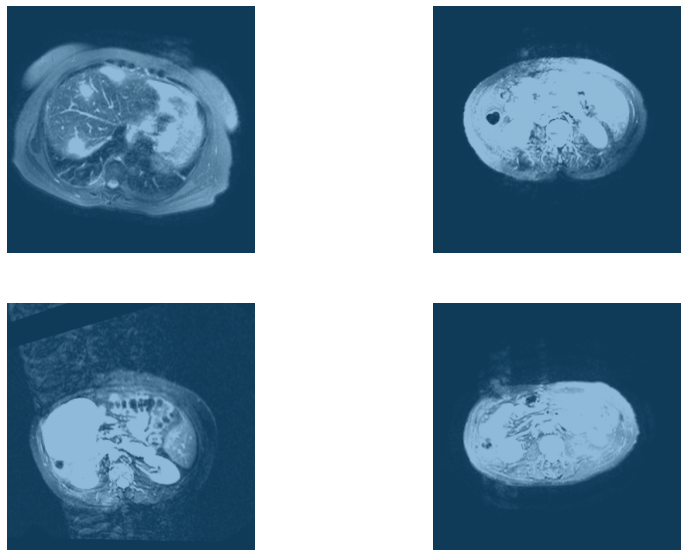

In [33]:
#Look at the batch

dls.show_batch(max_n=4, vmin=1, vmax=5, figsize=(14,10))

In [34]:
x1, y1=dls.one_batch()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [35]:
x1.shape

torch.Size([8, 3, 320, 320])

In [36]:
y1.shape #Notice the dimensions are batch size and the segmentation image dimensions

torch.Size([8, 320, 320])

In [37]:
def acc_1(inp, targ):
  targ = targ.squeeze(1)
  return (inp.argmax(dim=1)==targ).float().mean()

Now let's set up unet_learner. We are going to use the flag variable to change the set up depending on whether or not we are just targeting the liver or the liver and the other organs for segmentation. If we are doing multi-organ segmetnation we will change the metrics to have a multiclass version of the Dice coefficient.

In [38]:
if liverOnly:
  #For liver only labels
  learn = unet_learner(dls, resnet34, metrics=[Dice(),JaccardCoeff(),acc_1], self_attention=True)
  #For T2 we can expect to run for about 20 epochs to reach a Dice of 0.91, epochs take about 40 seconds to run
else:
  #For multi-organ targeting
  learn = unet_learner(dls, resnet34, metrics=[DiceMulti(),acc_1], self_attention=True)
  #For T2 we can reach a DiceMulti of 0.9 after about 30 epochs

  #We have swapped Dice() and JaccardCoeff() for DiceMulti() in the multi-label scenario



/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [39]:
learn.opt_func #Show the optimizer

<function fastai.optimizer.Adam>

In [40]:
learn.loss_func #Show the loss

FlattenedLoss of CrossEntropyLoss()

In [41]:
learn.summary() #Print a model summary

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


DynamicUnet (Input shape: 8 x 3 x 320 x 320)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 160 x 160  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 80 x 80    
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

Now we will start training. For 320x320 pixel images, it will take about 40 seconds to 1 minute per epoch. We can train for varying numbers of epochs depending on the sequence type which we are targetting. For T2, for example, we would recommend starting with about 20 to 25 epochs which will take less than 30 minutes to train. Further experimentation is encouraged!

In [42]:
lr1 = 1e-3

learn.fit_one_cycle(25,slice(lr1))

epoch,train_loss,valid_loss,dice,jaccard_coeff,acc_1,time
0,0.104672,0.114345,0.190184,0.105085,0.966784,00:31
1,0.079413,0.087656,0.152051,0.082281,0.966027,00:25
2,0.060189,0.031125,0.817407,0.691199,0.987550,00:25
3,0.045717,0.041919,0.744099,0.592483,0.984109,00:25
4,0.041832,0.047360,0.840514,0.724902,0.987231,00:25
5,0.035574,0.072547,0.774289,0.631706,0.980368,00:25
6,0.036088,0.023363,0.886078,0.795457,0.991479,00:25
7,0.030597,0.022427,0.887021,0.796979,0.991905,00:25
8,0.024460,0.034933,0.824045,0.700746,0.988424,00:25
9,0.022888,0.023524,0.884565,0.793022,0.991303,00:25


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [43]:
#Now save the model
learn.save('basicR34-Unet-MRsegmentation')


Path('models/basicR34-Unet-MRsegmentation.pth')

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


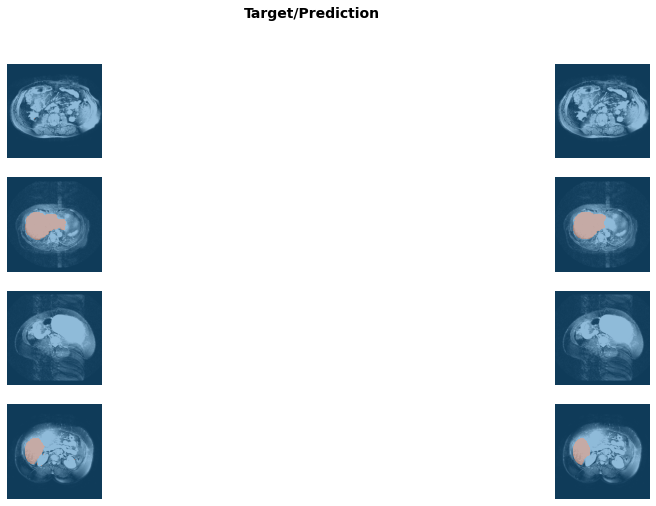

In [44]:
learn.show_results(max_n=4, figsize=(18,8))

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


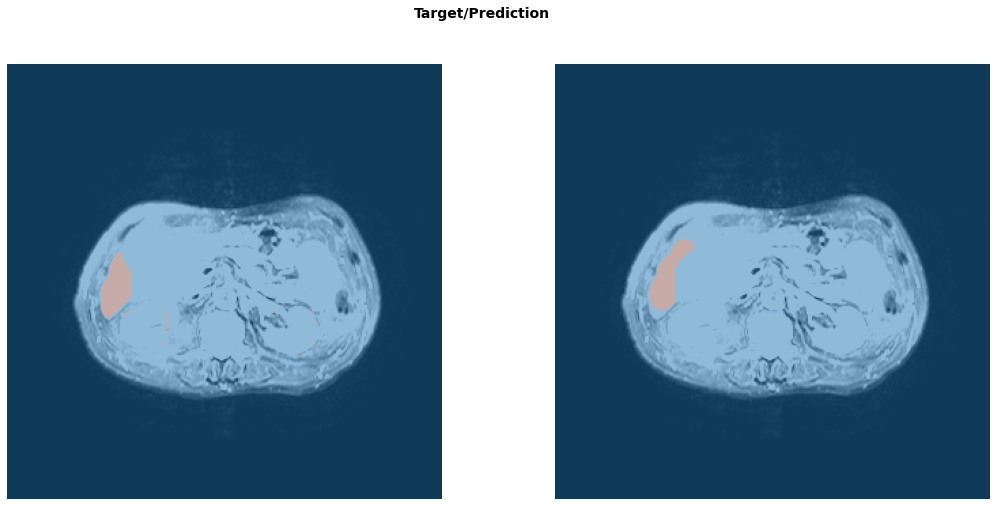

In [45]:
#Look at some images by re-running the cell.

learn.show_results(max_n=1, figsize=(18,8))

In [46]:
interp = SegmentationInterpretation.from_learner(learn)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


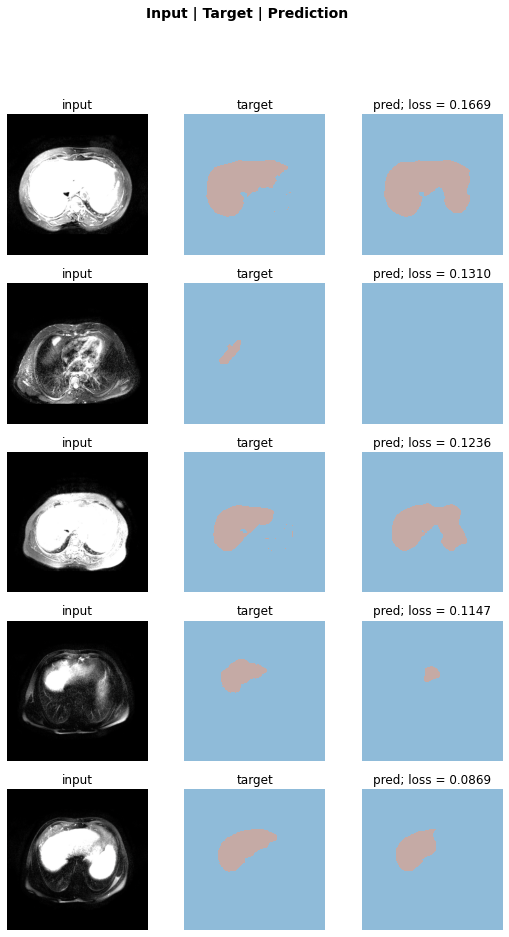

In [47]:
interp.plot_top_losses(5)

## Test Dataset Evaluation

Okay, now that we have trained a U-net, we are ready to start working with the test dataset

In [48]:
#First we will download the test dataset

!wget -q --show-progress https://zenodo.org/record/3431873/files/CHAOS_Test_Sets.zip?download=1

CHAOS_Test_Sets.zip 100%[===================>]   1.02G  18.5MB/s    in 9m 30s  


In [49]:

!unzip -q  CHAOS_Test_Sets.zip\?download\=1

Now we have the test dataset DICOMs but we don't have segmentations available. So we can use our model to make segmentation labels where none existed before. We are calling this a test dataset, and unlike the validation dataset we are not letting performance related to this data influence our model training. 

In [50]:
#Let's again simplify the DICOMs into a folder of TIFs

#We will make some new folders for our TIFs
if not os.path.exists('./images-T2-Test'):
  os.mkdir('./images-T2-Test')
if not os.path.exists('./images-T1-Test'):
  os.mkdir('./images-T1-Test')
if not os.path.exists('./images-T1-Out-Test'):
  os.mkdir('./images-T1-Out-Test')


#This executes quickly since we are not manipulating the images and just rearranging them

labelpathtest=Path('./Test_Sets/MR')
testls=os.listdir(labelpathtest)


for f1 in testls:

  #Loop through the T1 images

  dcls=sorted(os.listdir(labelpathtest/f1/'T1DUAL/DICOM_anon/InPhase'))
  dclsO=sorted(os.listdir(labelpathtest/f1/'T1DUAL/DICOM_anon/OutPhase')) #These dcms are offset as -1 relative to the in phase
  for x1 in range(0,len(dcls)):
    dcpick=labelpathtest/f1/'T1DUAL/DICOM_anon/InPhase'/dcls[x1]
    savestem=dcls[x1].split('.')[0]
    savenamekeep=str(f1)+'-'+savestem #Does not include character suffix
   
    mrex=pydicom.dcmread(dcpick)
    mrimg=mrex.pixel_array
    Image.fromarray(mrimg.astype(np.float32)).resize((fixsize,fixsize)).save('./images-T1-Test/'+str(f1)+'-'+savestem+'.tif')

    #Load the out phase under its filename but save it under the paired in phase filename in a separate folder
    dcpickO=labelpathtest/f1/'T1DUAL/DICOM_anon/OutPhase'/dclsO[x1]
    mrex=pydicom.dcmread(dcpick)
    mrimg=mrex.pixel_array
    Image.fromarray(mrimg.astype(np.float32)).resize((fixsize,fixsize)).save('./images-T1-Out-Test/'+str(f1)+'-'+savestem+'.tif')
    
    

  #Loop through the T2 images
  dcls2=sorted(os.listdir(labelpathtest/f1/'T2SPIR/DICOM_anon'))

  for x1 in range(0,len(dcls2)):
    dcpick=labelpathtest/f1/'T2SPIR/DICOM_anon'/dcls2[x1]

    savestem=dcls2[x1].split('.')[0]
    savenamekeep=str(f1)+'-'+savestem #Does not include character suffix
    mrex=pydicom.dcmread(dcpick)
    mrimg=mrex.pixel_array#pydicom.pixel_data_handlers.util.apply_modality_lut(mrex.pixel_array,mrex)
    Image.fromarray(mrimg.astype(np.float32)).resize((fixsize,fixsize)).save('./images-T2-Test/'+str(f1)+'-'+savestem+'.tif')



    


In [51]:
#Let's reminder ourselves what the testimagefoldername variable is based on our MR sequence flag that we set up earlier
print(testimagefoldername)

./images-T2-Test/


In [52]:
#Okay, now we will add these images as the test dataset for our U net model

dlt=learn.dls.test_dl(sorted(get_image_files(testimagefoldername)))

In [53]:
testnames=sorted(os.listdir(testimagefoldername))
len(testnames)

645

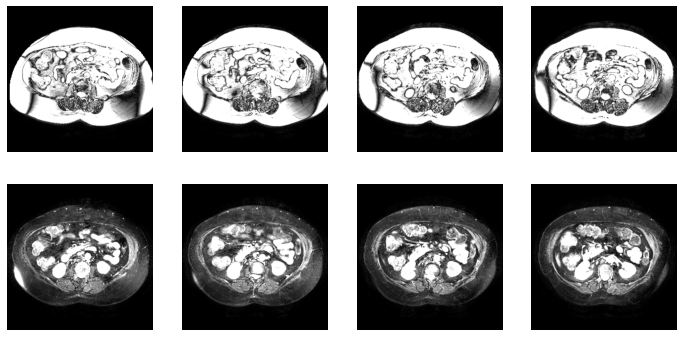

In [54]:
#Make sure it looks like what we expect
dlt.show_batch()

Okay, now let's use FastAI and our model to make predictions for this data.

In [55]:
preds = learn.get_preds(dl=dlt,reorder=False) #Compute our model segmentations

There are several possibilities for how we might want this data to be formatted depending on our end goal, so let's take some time to explore what the output of learn.get_preds looks like for our model. 

For this tutorial, we will composite the input image with the predictions so let's start by manipulating an example input

In [56]:
examplepick=10
testnames[examplepick]

'11-IMG-0049-00011.tif'

In [57]:
#In order to composite our images, we will want to convert our 16 bit TIF images into RGBA images where we can modify transparency/opacity of the images we are compositing
#This function will set us up for that conversion
def rescaletif(tifimage):
  tifimage2=np.round(255*np.divide(tifimage-np.min(tifimage),np.max(tifimage)-np.min(tifimage))).astype('uint8')
  return tifimage2

In [58]:
imgtestex=rescaletif(np.array(Image.open(testimagefoldername+testnames[examplepick])))

In [59]:
imgtestex.shape

(320, 320)

In [60]:
imgtestex2=Image.fromarray(imgtestex,mode='L').convert('RGBA')


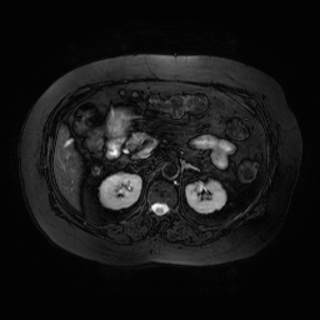

In [61]:
imgtestex2

Now let's turn our attention back to the prediction outputs

In [62]:
preds[0].shape
#For preds[0] have the first index as our test image count, the second index as the prediction classes,
#and the last 2 indices in the tensor as the image size (rows and columns)

torch.Size([645, 2, 320, 320])

In [63]:
preds[0][examplepick].shape #Select which image/prediction in our testdataset we want to work with

torch.Size([2, 320, 320])

In [64]:
pred1=to_np(preds[0][examplepick]) #Conver the tensor to a Numpy array

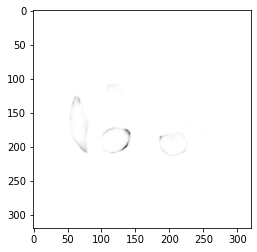

In [65]:
plt.imshow(pred1[0],cmap='gray') #These are predictions for the default class with white as higher probability.
#This is what we are predicting as background (not target organ)

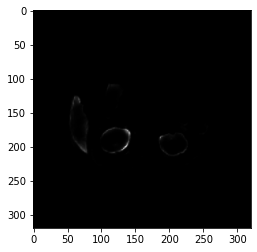

In [66]:
plt.imshow(pred1[1],cmap='gray') #These are predictions for the liver class

In [67]:
np.max(pred1[1]) #Max probability that a pixel is liver

0.10012561

In [68]:
pred1a=np.argmax(pred1,axis=0) #One useful way to look at these predictions is via argmax in order to see which class has the highest probability at each pixel
np.max(pred1a)

0

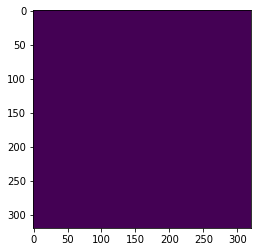

In [69]:
plt.imshow(pred1a)

In [70]:
pred1a.shape

(320, 320)

Now, we have many options for how we can overlay the input and predictions. For this example, we will make the predictions for liver occupy only the red color channel in a PNG and then composite that with the input

In [71]:
predR=np.stack((pred1a,np.zeros((fixsize,fixsize)),np.zeros((fixsize,fixsize))),axis=2) #Join arrays on a new axis
predR.shape

(320, 320, 3)

In [72]:
imgmask=Image.fromarray(np.round(predR*255).astype('uint8'),mode='RGB').convert('RGBA') #Convert the mask to a RGBA image

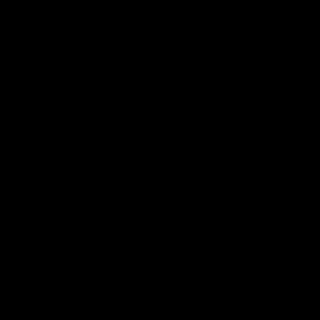

In [73]:
imgmask #Show the new mask

In [74]:
imgblend=Image.blend(imgtestex2,imgmask,0.25) #Blend the images

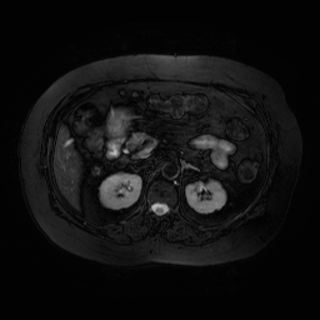

In [75]:
imgblend

Now even if this prediction looks suboptimal, we can still go ahead and use this format to look at the entire dataset if we would like. Let's create images like this for the entire test dataset.

In [76]:


if not os.path.exists('./images-Test-SegmentOverlay'):
  os.mkdir('./images-Test-SegmentOverlay')


numtest=len(testnames)
for xt in range(0,numtest):
  pred1=to_np(preds[0][xt])
  pred1a=np.argmax(pred1,axis=0)
  predR=np.stack((pred1a,np.zeros((fixsize,fixsize)),np.zeros((fixsize,fixsize))),axis=2) 
  imgmask=Image.fromarray(np.round(predR*255).astype('uint8'),mode='RGB').convert('RGBA')

  imgtestex=rescaletif(np.array(Image.open(testimagefoldername+testnames[xt])))
  imgtestex2=Image.fromarray(imgtestex,mode='L').convert('RGBA')

  imgblend=Image.blend(imgtestex2,imgmask,0.25)
  imgblend.save('./images-Test-SegmentOverlay/'+testnames[xt].split('.')[0]+'.png')


In [77]:
#Now let's download all the files we made locally (if we want to)

#-q suppresses output
#-r is recursive (not really needed with how we are arranging our files)

!zip -r -q testsegments.zip ./images-Test-SegmentOverlay

Now with Colab, once we have created a zip file with all of our composite images from the test dataset, we can programmatically download the zip file and then view the images with any local image viewer.

In [78]:
from google.colab import files

files.download("testsegments.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>